# Project 9: Segmentation of cell images with Cellari 
By Jonathan Gundorph Jansen (s153114) and Johanne Høst Thorkilsdatter (s175385) \




In [ ]:
#Check if RAM is already used
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  |     Proc size: 112.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total     15079MB


First all the needed packages and functions need to be imported

In [ ]:
#Import Numpy
import numpy as np

#import pillow
import PIL as pil 
from PIL import Image

#Import matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
#import matplotlib.patches as patches
import random
%matplotlib inline
from matplotlib import image

#Import torch
#!pip install torch torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
#torch.manual_seed(17)

from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

#Import pandas
import pandas as pd

#Import os
import os

#Import cv2
import cv2

#Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers#
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model

#Import zipfile
import zipfile

#Import scipy misc
from scipy import misc

#Improt imageio
import imageio

#Import shutil (for moving between folders)
import shutil

#import datetime
from datetime import datetime

#import io and itertools
import io
import itertools

#Import packaging and sixmoves
from packaging import version
from six.moves import range

#import sklearn metrics
import sklearn.metrics


from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label #for connected pixels
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb

# The dataset
The GLAND dataset is downloaded from Warwick webpage, and the downloaded file is then unzipped and all is extracted.

In [ ]:
## Download the GLAND dataset, if you haven't already

!if [ ! -f GLAND.npz ]; then wget -N https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip; else echo "Gland.npz already downloaded"; fi

#Unzip the file as a folder
with zipfile.ZipFile('warwick_qu_dataset_released_2016_07_08.zip', 'r') as zip_ref:
    zip_ref.extractall('warwick_qu_dataset_released_2016_07_08')
    

--2021-01-04 13:34:50--  https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 304 
File ‘warwick_qu_dataset_released_2016_07_08.zip’ not modified on server. Omitting download.



In the downloaded files from Warwick, is a csv file that contains information about the dataset. For this project we are only interested in analyzing the images and therefore will not need the patient ID or grade. \

The name of the images are not sorted in the dataframe so this will be done for convenience. To sort the images an extra column is created containing the number in the image name only. This is then used to sort the the rows.

In [ ]:
#Read in the .csv file
fileinfo = pd.read_csv('warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/Grade.csv')

fileinfo.columns = fileinfo.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
fileinfo = fileinfo.rename(columns={'grade_sirinukunwattana_et_al._2015': 'grade'})
fileinfo.head()

,name,patient_id,grade_glas,grade
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated


In [ ]:
#sort the names to make it easier later
fileinfo['sort'] = fileinfo['name'].str.extract('(\d+)', expand = False).astype(int)
fileinfo.sort_values('sort',inplace=True, ascending=True)
fileinfo = fileinfo.reset_index()
fileinfo = fileinfo.drop('index', axis=1)
fileinfo.head()
#fileinfo = fileinfo.drop('sort', axis=1)

,name,patient_id,grade_glas,grade,sort
0,testA_1,4,benign,adenomatous,1
1,testB_1,3,malignant,moderately differentiated,1
2,train_1,2,malignant,moderately differentiated,1
3,testB_2,7,malignant,moderately differentiated,2
4,train_2,5,benign,adenomatous,2


The images are already divided into training and test data with their corresponding ground truth annotated image. The annotated images has the same name as their corresponding "raw" image. So image "testA_1" has an annotated image called "testA_1_anno". \
The image locations are loaded into lists to easy access them. There is a total of 85 training images and 80 test images. 

In [ ]:
train_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('train'),'name'].values]
test_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('test'),'name'].values]
anno_train_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}_anno.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('train'),'name'].values]
anno_test_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}_anno.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('test'),'name'].values]
print("Number of training examples:",len(train_images))
print("Number of test examples:",len(test_images))
print("Total number of images:", (len(test_images)+len(train_images)))


Number of training examples: 85
Number of test examples: 80
Total number of images: 165


From the plot below five of the training images are shown together with their annotated masks. Each mask have a different color which among other things can be used to count the number of cells in the image.

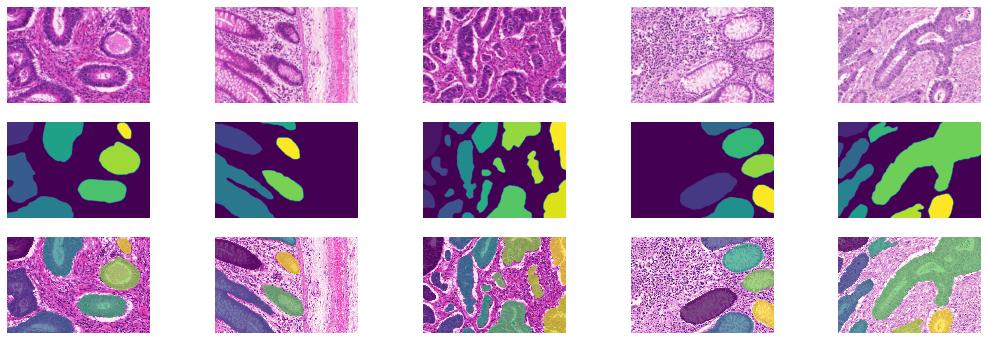

In [ ]:
## Visualize training and test set samples
amount = 5
# Define figure size


#Visualize pictures
fig, ax = plt.subplots(3, amount, figsize=(18, 6))
#training
image_sample = train_images[:amount]
for i, path in enumerate(image_sample):
    image = imageio.imread(path, as_gray=False)    
    ax[0,i].imshow(image)
    ax[0,i].axis('off')

#annotation
image_sample = anno_train_images[:amount]
for i, path in enumerate(image_sample):
    image = imageio.imread(path, as_gray=False)    
    ax[1,i].imshow(image)
    ax[1,i].axis('off')

#with mask overlay
image_sample = train_images[:amount]
for i, path in enumerate(image_sample):
    image = imageio.imread(path, as_gray=False)    
    ax[2,i].imshow(image, interpolation='none')
    ax[2,i].axis('off')


image_sample = anno_train_images[:amount]
for i, path in enumerate(image_sample):
    image = imageio.imread(path, as_gray=False)
    mask = np.ma.masked_where(image == 0, image) 
    ax[2,i].imshow(mask, interpolation='none', alpha=0.7)



# Create the dataset
To load the image information into the Mask R-CNN, a custom PyTorch class for loading and creating the cell image dataset is created. This class contains methods that are to be used in the PyTorch Dataloader

In the dataset creation the following is done: \
1)
Defines paths for images, transforms and masks.

2)
Loads in the images and masks, get unique pixel values for each "class" (background/foreground or cell), define masks and bounding boxes around each mask.
Convert everything into tensors


In [ ]:
class CellDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transforms=None):
        '''
        Args: 
          images: Directory with all the images
          masks: Directory with all the masks
          transform (callable, optional): Optional transform 
            to be applied on a sample
        '''
        self.imgs = images
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, idx):
        '''
        Open image and mask at index idx
        Resize to fit Mask R-CNN
        '''
        img= Image.open(self.imgs[idx])
        img = img.resize([512,512], resample=0)
        mask = Image.open(self.masks[idx])
        mask = mask.resize([512,512], resample=0)

        mask = np.asarray(mask)

        #Create list with each unique datavalue for masks
        #to count number of masks
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])+0.1 #Added to avoid bug
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])+0.1
            boxes.append([xmin, ymin, xmax, ymax])
          
        #Make to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        #Create a dictionary to store data values
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Training and evaluation functions
Get helper functions to simplify training and evaluating detection models, and copy them and their dependencies here

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
#git checkout v0.8.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../ #Might not need this as we don't use coco

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


# Create a instance segmentation model for our dataset, using Mask R-CNN, and finetune from a pre-trained model

A Mask R-CNN model is downloaded from torchvision.
The model uses ResNet-50-FPN backbone and the weights are already pre-trained on the COCO dataset.  

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

 #https://github.com/pytorch/vision/blob/80f41f8d32b1fcb380d5df2116063af7034ff29a/torchvision/models/detection/faster_rcnn.py     
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

# Define helper functions for data augmentation/transformation
When the model is training, it starts with some "training warm-up steps" which means that the learning rate is low in the beginning, for the warm-up steps, and afterwards the regular learning rate is used. In the function *train_one_epoch* it is only the first epoch, that is treated as a warm-up.

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T #From the github clone pytorch/vision/references/detection/transforms.py

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        #transforms.append(T.RandomRotation(270, resample=False, expand=False, center=None, fill=None))
        #transforms.append(T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)) #Randomly change the brightness, contrast and saturation of an image.
    return T.Compose(transforms)

# Instantiate the models and data transforms, using the defined dataset class

The custom dataloader will be used to create two dataset: One with the training data and one for testing the model. \
\
The dataset will the be inserted into a Pytorch Dataloader, where the data is shuffled and a specific batch size is defined. This will be the input to the Mask R-CNN. \


In [ ]:
# use our dataset and defined transformations
dataset = CellDataset(train_images, anno_train_images, get_transform(train=True))
dataset_test = CellDataset(test_images, anno_test_images, get_transform(train=False))

# define training data loader
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

# define testing data loader 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Instantiate the model and the optimizer

As a default, tensors are created in the main memory and then CPU is used to calculate it. We want to train on the GPU if it is avaliable.
It is important to make sure that the operations are on the same device to make sure the framework knows where to store the results or where to perform the computation. \
\
After some tests the Stochastic Gradient Descent (SGD) is used as the optimizer with a learning rate of 0.005, momentum of 0.9 and a weight decay of 0.005. \
A learning rate scheduler is used to decrease the learning rate by a rate of 10x every 3 epochs. This helps both the optimization and generalization


In [ ]:
# Use a GPU cuda if possible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and cell
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

#Stochastic Gradient Descent (SGD) optimizer:
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs (Decreases in discrete steps/discrete staircase)
#(Learning rate decay. See: https://www.youtube.com/watch?v=QzulmoOg2JE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Train the model for a number of epochs, evaluating at the end of every epoch

In [ ]:
# Define number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 20)

    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch 1/200
--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Streaming af output blev afkortet til de sidste 5000 linjer.
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.757
Epoch 8/200
--------------------
Epoch: [7]  [ 0/43]  eta: 0:01:05  lr: 0.000050  loss: 0.3719 (0.3719)  loss_classifier: 0.0981 (0.0981)  loss_box_reg: 0.1345 (0.1345)  loss_mask: 0.1033 (0.1033)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0316 (0.0316)  time: 1.5126  data: 0.9374  max mem: 2439
Epoch: [7]  [10/43]  eta: 0:00:20  lr: 0.000050  loss: 0.5512 (0.7524)  loss_classifier: 0.1488 (0.1450)  loss_box_reg: 0.2026 (0.2132)  loss_mask: 0.1862 (0.1904)  loss_objectness: 0.0130 (0.0190)  loss_rpn_box_reg: 0.0185 (0.1848)  time: 0.6142  data: 0.0899  max mem: 2439
Epoch: [7]  [20/43]  eta: 0:00:13  lr: 0.000050  loss: 0.5638 (0.6555)  loss_classifier: 0.1293 (0.1328)  loss_box_reg: 0.2221 (0.2145)  loss_mask: 0.1783 (0.1857)  loss_objectness: 0.0149 (0.01

# Test evaluation metrics on the Mask R-CNN output after training
After training, the Mask R-CNN is evaluated using a number of different metrics: F1 score, F1 object score, IoU (Intersection over Union) score, IoU object score and Hausdorff object distance. \
The code for evaluation is already given by the supervisor but there were a complication when loading the github repository, BinaryImageMetrics class given by the supervisor from https://github.com/petoor/ImageMetrics \
It is therefore copy-pasted below. \
\
It is worth noting that get_count counts overlapping predicted masks as one. The count ratio would therefore be different if the number of predicted masks were used to calculate this instead of the label-function. Therefore this function is not used when calculating count ratio

In [ ]:
#Clone github repository
!git clone https://github.com/scikit-image/scikit-image.git
os.chdir('/content/scikit-image/skimage/metrics')
from set_metrics import hausdorff_distance
#Change directory back
os.chdir('/content')
class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):

        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=si, y_pred=gi)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_y_pred = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_y_pred == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_y_pred)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_y_pred)*self.get_hausdroff_dist(y_true=si, y_pred=gi)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true = np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred = (roi_y_pred==matching_idx)*1
        
        return roi_y_true, roi_y_pred
        
    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y
        

# Examine what is predicts in a test image
When the output is computed from the model, the model needs to be put in *eval mode*. That way, the layers will work in eval mode instead of training mode. The *torch.no_grad()* deactivate the autograd engine and reduces memory usage which speeds up the computation. 

Now, we inspect the image and the predicted segmentation masks.
Since the model will give a score of how confident it is, that the given mask is an actual class, a threshold have been chosen to filter out the masks with a low confident. But to still get some output it have been set to at least print three predicted cells no matter what

In [ ]:
#chose one image to examine
chosen_img = 71
img, _ = dataset_test[chosen_img]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


#Confident scores
S = prediction[0]['scores']
S_highest = torch.max(S).item()
#Create a threshold for when the model is sure enough for the pixel being a cell
thres = 0.77
S_thres = sum(S >= thres).item()
S_thres = max(S_thres, 2) #output at least 3 cells
S_lowest = S[0:S_thres] #Lowest confident score for image masks
S_lowest = torch.min(S_lowest).item()


#### True masks ####
true_mask = anno_test_images[chosen_img]
true_mask = Image.open(true_mask)
true_mask = true_mask.resize([512,512], resample=0)
true_mask = np.uint8(true_mask)


#### Define plot ####
fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,15))


#### Plot input image ####
image_input = dataset_test[chosen_img][0]
image_input = image_input.permute(1,2,0)
ax1.imshow(image_input)
ax1.set_title('Original image no. {}'.format(chosen_img+1))


#### Predicted bounding boxes ####
ax2.imshow(true_mask)
ax2.set_title('Original mask no. {} with pred. bboxes'.format(chosen_img+1))
#Gives lower left corner (xmin, ymin) and upper right corner (xmax,ymax) of the i'th bounding box (out of n cells (len(mask1)) ) for the mask/image in question
box1 = prediction[0]['boxes'][:S_thres]
for k in range(len(box1)):
  xmin = int(box1[k][0]) #x coord of Lower left corner
  ymin = int(box1[k][1]) #y coord of Lower left corner
  xmax = int(box1[k][2]) #x coord of Upper Right corner
  ymax = int(box1[k][3]) #y coord of Upper Right corner
  h = ymax - ymin #Height of the bounding box
  w = xmax-xmin #width of the bounding box

  # Create a Rectangle patch
  rect = mpatches.Rectangle((xmin,ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')

  # Add the patch to the Axes
  #ax6.add_patch(rect)
  ax2.add_patch(rect)


#Make the mask it is most confident about the base image to apply the other masks to
pred_masks_all = prediction[0]['masks'].mul(255).byte().cpu().numpy()
#add the masks together
pred_mask = sum(pred_masks_all[0])
for k in range(1,S_thres):
  pred_mask += sum(pred_masks_all[k])
ax3.imshow(image_input, interpolation='none')
mask = np.ma.masked_where(pred_mask == 0, pred_mask) 
ax3.imshow(mask, interpolation='none', alpha=0.8)
ax3.set_title('Predicted masks with threshold {:.3f}'.format(S_lowest))

metrics = BinaryImageMetrics(true_mask,pred_mask)
count_true = np.max(true_mask)
count_pred = S_thres
if count_pred == 0 or count_true == 0:
  count_ratio = 0.0
else:
  count_ratio = min(count_true/count_pred, count_pred/count_true)
print(f"Count ratio is: {count_ratio}")
#print("Number of predicted masks are",S_thres)
f1 = metrics.get_f1()
print(f"F1 score is : {f1}")
f1_obj = metrics.get_f1_obj()
print(f"F1 object score is: {f1_obj}")

hausdorff_obj_distance = metrics.get_hausdorff_obj_distance()
print(f"Hausdroff object distance score is : {hausdorff_obj_distance}")


# Calculate all metrics
The code below is used to create plots for all the test images. The code to save the images has been commented out. Some of the output images can be seen in the report.

In [ ]:
hausdorff_obj_distance_all = [] #Storage container for all hausdorff image scores
IoU_all = [] #Storage container for all IoU scores
IoU_obj_all = [] #Storage container for all IoU_obj scores
F1_all = [] #Storage container for all F1 scores
F1_obj_all = [] #Storage container for all F1_obj scores
Count_all = []

xmaxlim = 80 #number of test images

for chosen_img in range(0,xmaxlim):
  img, _ = dataset_test[chosen_img]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  
  #Confident scores
  S = prediction[0]['scores']
  S_highest = torch.max(S).item()
  #Create a threshold for when the model is sure enough for the pixel being a cell
  thres = 0.77
  S_thres = sum(S >= thres).item()
  S_thres = max(S_thres, 2) #output at least 3 cells
  S_lowest = S[0:S_thres] #Lowest confident score for image masks
  S_lowest = torch.min(S_lowest).item()


  #### True masks ####
  true_mask = anno_test_images[chosen_img]
  true_mask = Image.open(true_mask)
  true_mask = true_mask.resize([512,512], resample=0)
  true_mask = np.uint8(true_mask)


  #### Define plot ####
  fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,15))


  #### Original image ####
  image_input = dataset_test[chosen_img][0]
  image_input = image_input.permute(1,2,0)
  ax1.imshow(image_input)
  ax1.set_title('Original image no. {}'.format(chosen_img+1))


  #### Predicted bounding boxes ####
  ax2.imshow(true_mask)
  ax2.set_title('Original mask no. {} with pred. bboxes'.format(chosen_img+1))
  #Gives lower left corner (xmin, ymin) and upper right corner (xmax,ymax) of the i'th bounding box (out of n cells (len(mask1)) ) for the mask/image in question
  box1 = prediction[0]['boxes'][:S_thres]
  for k in range(len(box1)):
    xmin = int(box1[k][0]) #x coord of Lower left corner
    ymin = int(box1[k][1]) #y coord of Lower left corner
    xmax = int(box1[k][2]) #x coord of Upper Right corner
    ymax = int(box1[k][3]) #y coord of Upper Right corner
    h = ymax - ymin #Height of the bounding box
    w = xmax-xmin #width of the bounding box

    # Create a Rectangle patch
    rect = mpatches.Rectangle((xmin,ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    #ax6.add_patch(rect)
    ax2.add_patch(rect)

  #Make the mask it is most confident about the base image to apply the other masks to
  pred_masks_all = prediction[0]['masks'].mul(255).byte().cpu().numpy()
  #add the masks together
  pred_mask = sum(pred_masks_all[0])
  for k in range(1,S_thres):
    pred_mask += sum(pred_masks_all[k])
  ax3.imshow(image_input, interpolation='none')
  mask = np.ma.masked_where(pred_mask == 0, pred_mask) 
  ax3.imshow(mask, interpolation='none', alpha=0.8)
  ax3.set_title('Predicted masks with threshold {:.3f}'.format(S_lowest))


  
  ###########################################################################################
  #### Define metrics ####
  
  metrics = BinaryImageMetrics(true_mask, pred_mask)
  count_true = np.max(true_mask)
  count_pred = S_thres
  if count_pred == 0 or count_true == 0:
    count_ratio = 0.0
  else:
    count_ratio = min(count_true/count_pred, count_pred/count_true)

  Count_all.append(count_ratio)
  f1 = metrics.get_f1()
  F1_all.append(f1)
  f1_obj = metrics.get_f1_obj()
  F1_obj_all.append(f1_obj)
  IoU = metrics.get_iou()
  IoU_all.append(IoU)
  IoU_obj = metrics.get_iou_obj()
  IoU_obj_all.append(IoU_obj)
  hausdorff_obj_distance = metrics.get_hausdorff_obj_distance()
  hausdorff_obj_distance_all.append(hausdorff_obj_distance)
 
  #print('Threshold: {:.3f} \n True_count: {:.3f}, Pred_cont = {:.3f} Count_ratio: {:.3f} \n F1: {:.3f} -- F1_object: {:.3f} \n IoU: {:.3f} -- IoU_object: {:.3f} -- Hausdorff: {:.3f}'.format(thres_upd,count_true,count_pred,count_ratio,f1,f1_obj,IoU,IoU_obj, hausdorff_obj_distance))

  #plt.savefig('output{}'.format(chosen_img+1))
  plt.close(fig='all')
 


# Metrics scores
To better understand the results from the metrics, they are plottet together for all test images with a mean value

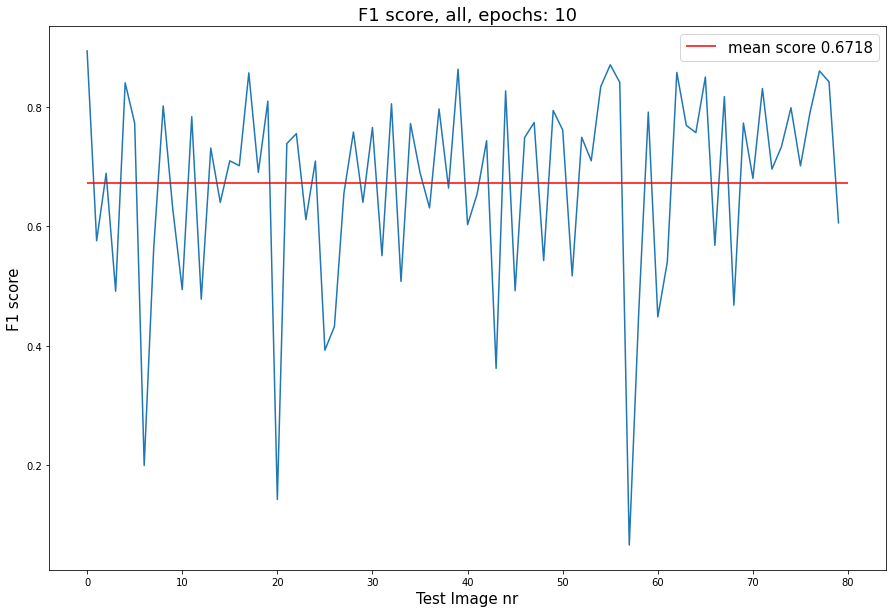

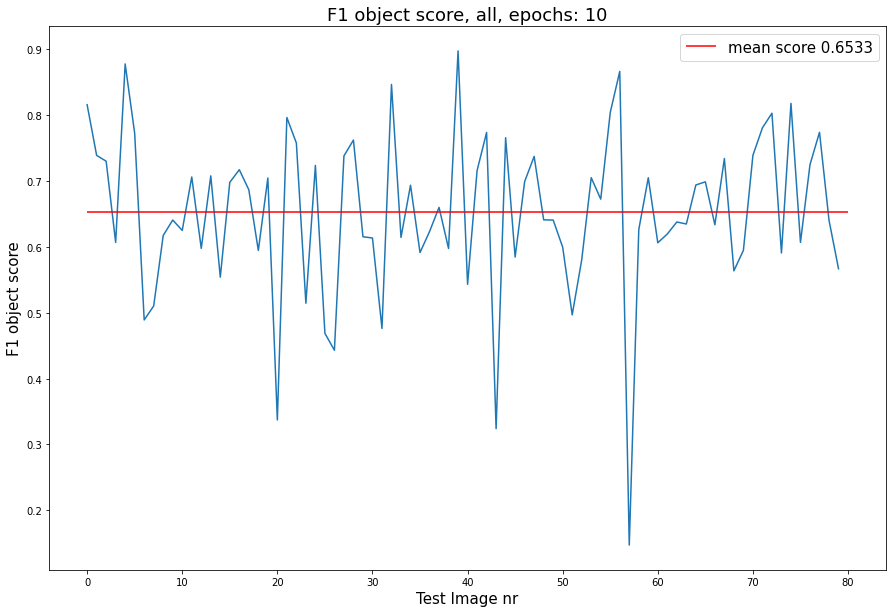

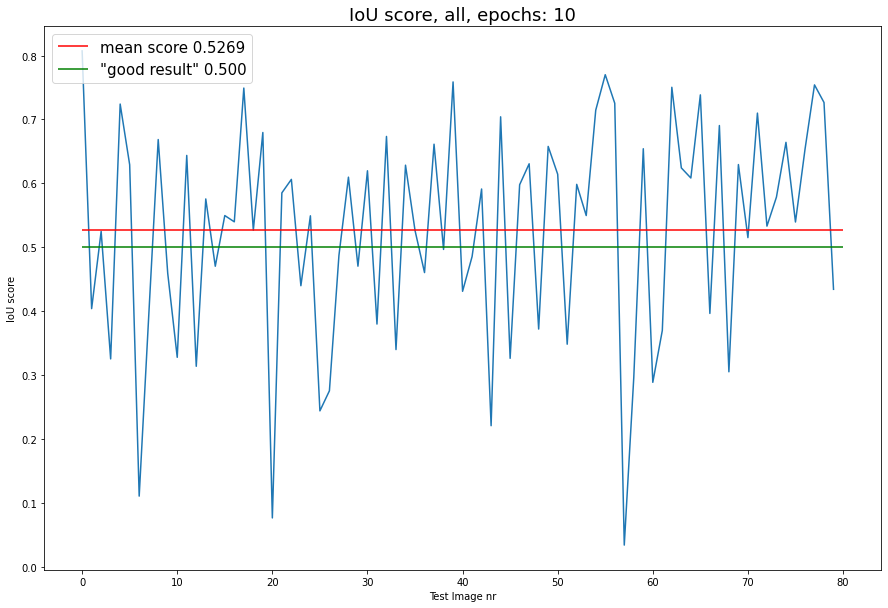

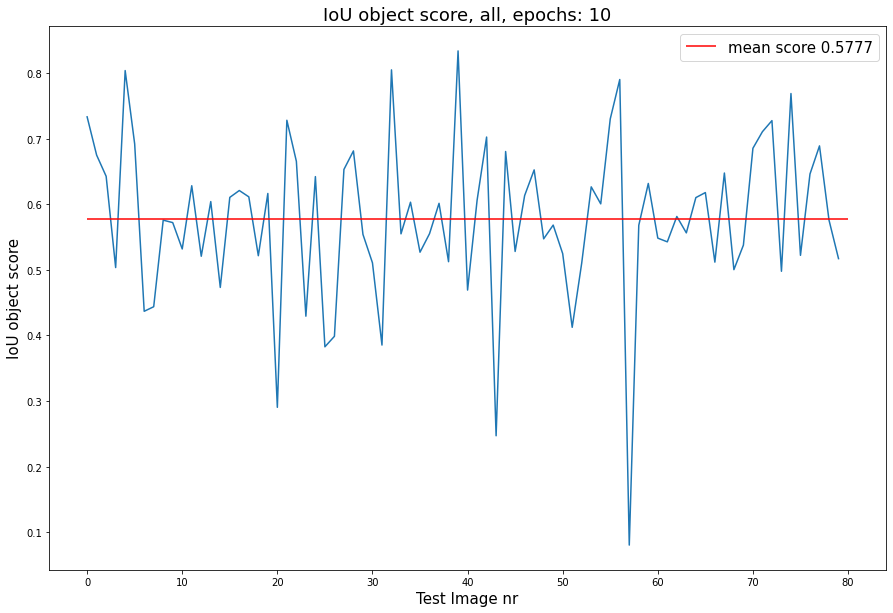

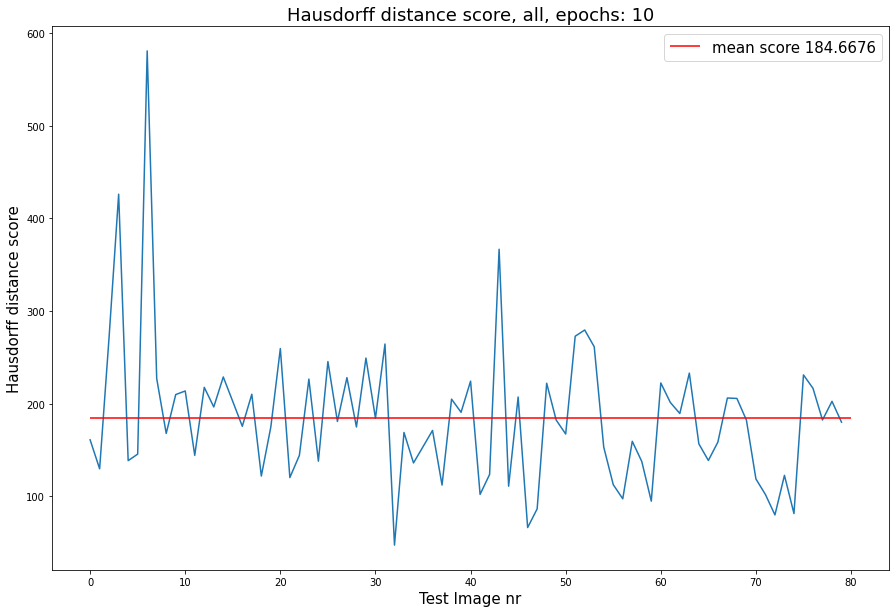

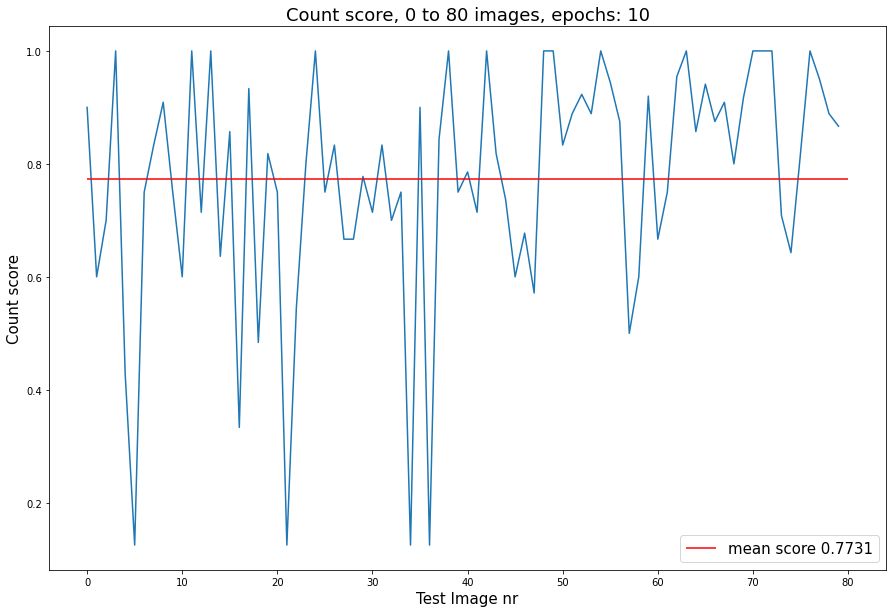

In [ ]:
#F1 score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(F1_all)
F1_mean = np.mean(F1_all)
plt.title('F1 score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('F1 score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
#x_coordinates = [0, 511]
#y_coordinates = [F1_mean, F1_mean]
#plt.plot(x_coordinates, y_coordinates)
plt.hlines(F1_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(F1_mean))
ax.legend(prop={"size":15})
#F1 object score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(F1_obj_all)
F1_obj_mean = np.mean(F1_obj_all)
plt.title('F1 object score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('F1 object score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(F1_obj_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(F1_obj_mean))
ax.legend(prop={"size":15})
#IoU score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(IoU_all)
IoU_mean = np.mean(IoU_all)
plt.title('IoU score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('IoU score')
plt.xlabel('Test Image nr')
plt.hlines(IoU_mean, 0, 80,colors="r", zorder=100, label='mean score {:.4f}'.format(IoU_mean))
plt.hlines(0.5, 0, xmaxlim,colors="g", zorder=100, label='"good result" {:.3f}'.format(0.50))
ax.legend(loc='upper left',prop={"size":15})
#IoU Object score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(IoU_obj_all)
IoU_obj_mean = np.mean(IoU_obj_all)
plt.title('IoU object score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('IoU object score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(IoU_obj_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(IoU_obj_mean))
ax.legend(prop={"size":15})
#Hausdorff distance score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(hausdorff_obj_distance_all)
Hausdorff_mean = np.mean(hausdorff_obj_distance_all)
plt.title('Hausdorff distance score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('Hausdorff distance score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(Hausdorff_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(Hausdorff_mean))
ax.legend(prop={"size":15})
#Count score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(Count_all)
Count_mean = np.mean(Count_all)
plt.title('Count score, 0 to {} images, epochs: {}'.format(xmaxlim,num_epochs), fontsize=18)
plt.ylabel('Count score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(Count_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(Count_mean))
ax.legend(prop={"size":15})

Code to downloade the saved images

In [ ]:
# from google.colab import files
# for chosen_img in range(0,80):
#   files.download('output{}.png'.format(chosen_img+1))




---



---


# Implementation of U-Net


---


# Defines paths for images
Since the data is already loaded in the first part of the notebook we can go ahead and create arrays with the path to each of the training and test images together with their annotated images. This will be used in the dataloader.

In [ ]:
anno_train_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}_anno.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('train'),'name'].values]
anno_test_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}_anno.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('test'),'name'].values]
train_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('train'),'name'].values]
test_images = ['warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/{}.bmp'.format(i) for i in fileinfo.loc[fileinfo['name'].str.contains('test'),'name'].values]

# Load and standardize images
To standardize the images the mean and standard diviation is needed. To calculate this for all images and for each of the three channels, a function is created which can output these values.

In [ ]:
def get_mean_std(img_folder, IMG_WIDTH=512, IMG_HEIGHT=512): 
  img_data=[]
  #class_name=[]
  for file in img_folder:
    image_path= file
    image= Image.open(image_path)
    
    image = image.resize([IMG_HEIGHT,IMG_WIDTH], resample=0)
    image = np.asarray(image)
    image = image.astype('float32')
    img_data.append(image)
  
  #calculate mean and std, for each channel
  mean = np.mean(np.mean(img_data, axis=(0,1)),axis=0)
  std = np.mean(np.std(img_data, axis=(0,1)),axis=0)

  return mean, std

In [ ]:
img_mean, img_std = get_mean_std(train_images)
test_mean, test_std = get_mean_std(test_images)

Then the dataset is created by using the class based on PyTorchs function.

In [ ]:
class UNetDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transforms=None):
        # load all image files
        self.imgs = images
        self.masks = masks
        self.transforms = transforms


    def __getitem__(self, idx):
        img = self.imgs[idx]
        img= Image.open(self.imgs[idx])
        img = img.resize([512,512], resample=0)
        img = np.array(img)
        img_trans = img.transpose((2,0,1))

        
        mask = Image.open(self.masks[idx])
        mask = mask.resize([512,512], resample=0)
        mask = np.array(mask)
        mask = np.where(mask > 0, 1, mask) #only one class

        if self.transforms is not None:
            img = self.transforms(img)
        image = img_trans
        
        return image, mask

    def __len__(self):
        return len(self.imgs)

The transformation function normalize the images which is where the calculated mean and standard diviation are needed. \
The trainin data and test data is then composed and given to the dataloader with a batch size of 6 for the training images and a batch size of one for the test images.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean= img_mean, std = img_std)]
)

trainset = UNetDataset(train_images, anno_train_images, transforms=transform)

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean= test_mean, std = test_std)]
)

testset = UNetDataset(test_images, anno_test_images, transforms=transform_test)



classes = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)

# Training data
Number of points: 85
Batch dimension [B x C x H x W]: torch.Size([6, 3, 512, 512])


# Defining the U-Net
Now the images are ready to be fed to the model and the next step is therefore to define the U-Net. Unlike the version from the original paper, zero padding is used to make sure that the output size is the same as the input size \
The input dimension is: [b,c,h,w,] = [1,512,512,3]
\
\
The left part of the U-Net is just a simple convolution network. Two 3x3 Convolution layers are followed by a Relu activation function that are stacked together (Sequentially) and a 2x2 maxpool layer is applied after that.
\
\
Right part also uses two 3x3 Convolution layers stacked together (Sequentially) like left side but has no Relu activation function and there is no maxpool layer. Instead a 2x2 Transpose convolution layer is used. During the expansion path, a copy of the image from the left side is taken and combined with the image on the right
\
Code from: https://becominghuman.ai/implementing-unet-in-pytorch-8c7e05a121b4

Two sequens of the code are used multiple times and is therefore defined as a function

In [ ]:
# besides for the first double conv, the output size needs to be 2*(input size)
# Padding = 1 to keep the input size for 512x512x3
def double_conv(in_channel, out_channel):
  conv = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1),
      nn.ReLU(inplace = True))
  return conv


#crop function for when combining image from left size
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels = 3, n_classes =2):
    super(UNet, self).__init__()
    self.in_channels = in_channels
    self.n_classes = n_classes

    self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.down_conv1 = double_conv(in_channels,64)
    self.down_conv2 = double_conv(64,128)
    self.down_conv3 = double_conv(128,256)
    self.down_conv4 = double_conv(256,512)
    self.down_conv5 = double_conv(512,1024)


    #Decoder
    self.trans1 = nn.ConvTranspose2d(1024, 512, 
                                        kernel_size = 2,
                                        stride = 2)
    self.up_conv1 = double_conv(1024, 512)

    self.trans2 = nn.ConvTranspose2d(512, 256, 
                                        kernel_size = 2,
                                        stride = 2)
    self.up_conv2 = double_conv(512, 256)

    self.trans3 = nn.ConvTranspose2d(256, 128, 
                                        kernel_size = 2,
                                        stride = 2)
    self.up_conv3 = double_conv(256, 128)

    self.trans4 = nn.ConvTranspose2d(128, 64, 
                                        kernel_size = 2,
                                        stride = 2)
    self.up_conv4 = double_conv(128, 64)

    self.out = nn.Conv2d(64, n_classes, kernel_size = 1)


  def forward(self, image):
    #Encoder
    x1 = self.down_conv1(image)
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)


    # Decoder
    x = self.trans1(x9)
    y = crop_tensor(x, x7)
    x = self.up_conv1(torch.cat([x,y], 1))

    x = self.trans2(x)
    y = crop_tensor(x, x5)
    x = self.up_conv2(torch.cat([x,y], 1))

    x = self.trans3(x)
    y = crop_tensor(x, x3)
    x = self.up_conv3(torch.cat([x,y], 1))

    x = self.trans4(x)
    y = crop_tensor(x, x1)
    x = self.up_conv4(torch.cat([x,y], 1))
    
    x = self.out(x)
    
    return x


# Train the model
The model is then trained for a number of epochs. Each epoch takes longer time in the U-Net compared to the Mask R-CNN and therefore is the number of epochs much lower for the U-Net than for the Mask R-CNN
\
Since it is a binary classification problem, Tte optimizer used is the Adam with a learning rate of 0.0001 and Cross Entropy Loss as the loss function. \
The training and validation loss are computed after each epoch to see the development and were also used to determine the learning rate.

In [ ]:
def acc_metric(predb, yb, device):
    return (predb.argmax(dim=1) == yb.to(device=device)).float().mean()

import torch.optim as optim
import time

model = UNet(in_channels=3,n_classes=2)
train_dl = trainloader
valid_dl = testloader

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

###############################
#Time per epoch: 40 minutes
epochs = 5
num_epochs = epochs
################
start = time.time()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


train_loss, valid_loss = [], []

best_acc = 0.0

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)  # Set trainind mode = true
            dataloader = train_dl
        else:
            model.train(False)  # Set model to evaluate mode
            dataloader = valid_dl

        running_loss = 0.0
        running_acc = 0.0

        step = 0

        # iterate over data
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.type(torch.LongTensor)
            y = y.to(device=device)
            step += 1
            

            # forward pass
            if phase == 'train':
                # zero the gradients
                optimizer.zero_grad()
                outputs = model(x)
                loss = loss_fn(outputs, y)

                # the backward pass frees the graph memory, so there is no 
                # need for torch.no_grad in this training pass
                loss.backward()
                optimizer.step()
                # scheduler.step()

            else:
                with torch.no_grad():
                    outputs = model(x)
                    loss = loss_fn(outputs, y.long())

            # stats - whatever is the phase
            acc = acc_metric(outputs, y, device)

            running_acc  += acc*dataloader.batch_size
            running_loss += loss*dataloader.batch_size 


        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_acc / len(dataloader.dataset)

        print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

        train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

time_elapsed = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    


Epoch 1/5
----------
train Loss: 0.7097 Acc: 0.6350885629653931
valid Loss: 0.7349 Acc: 0.5165124535560608
Epoch 2/5
----------
train Loss: 0.6943 Acc: 0.6453872919082642
valid Loss: 0.6854 Acc: 0.5822245478630066
Epoch 3/5
----------
train Loss: 0.6923 Acc: 0.6638815402984619
valid Loss: 0.6712 Acc: 0.587639331817627
Epoch 4/5
----------
train Loss: 0.6745 Acc: 0.6739974617958069
valid Loss: 0.6731 Acc: 0.5931887030601501
Epoch 5/5
----------
train Loss: 0.6678 Acc: 0.6751494407653809
valid Loss: 0.6552 Acc: 0.6004523634910583
Training complete in 2m 15s


In [ ]:
#Training 15 epochs: 6,18 hours

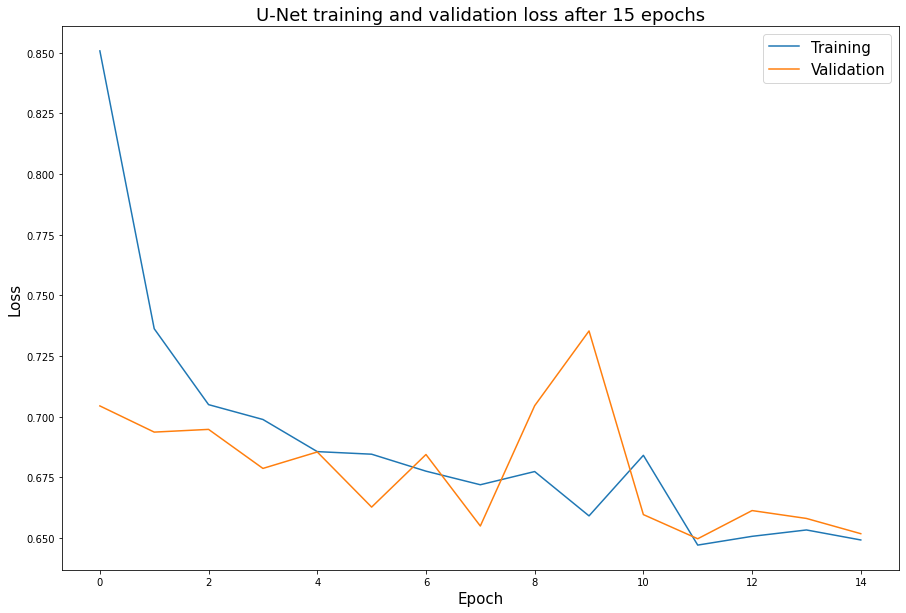

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(0,15),train_loss, label = "Training")
plt.plot(range(0,15), valid_loss, label = "Validation")
plt.title("U-Net training and validation loss after 15 epochs",fontsize=18)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend(prop={"size":15})
plt.show()

# U-Net output
The output for U-Net looks slightly different than the Mask R-CNN since U-Net only does pixel segmentation. \
First we take a look at one of the predictions for a test image.

In [ ]:
#test model
img_nr = 72
t_image, mask = testset[img_nr]
t_image = torch.from_numpy(t_image).unsqueeze(0).float()
model = model.float()
model.eval()
with torch.no_grad():
    outputs = model(t_image) 
    pr = torch.exp(outputs) # get the exp of output and will give the probability map of outpus
    # The outputs are energies for the 2 classes.
    # Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:     
    _, predicted = torch.max(outputs.data, 1) 

fig, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.imshow(t_image.squeeze(0).permute(1, 2, 0).int())
ax1.set_title('Image no {}'.format(img_nr+1))
ax2.imshow(mask)
ax2.set_title('Original mask no {}'.format(img_nr+1))
ax3.imshow(predicted.squeeze(0))
ax3.set_title('Predicted mask {}'.format(img_nr+1))
plt.show()

# Get metrics for U-Net

In [ ]:
true_masks = []
pred_pixels = []
hausdorff_obj_distance_all = [] #Storage container for all hausdorff image scores
F1_all = [] #Storage container for all F1 scores
F1_obj_all = [] #Storage container for all F1_obj scores

#test model
for img_nr in range(len(testset)):
    t_image, mask = testset[img_nr]
    t_image = torch.from_numpy(t_image).unsqueeze(0).float()
    model = model.float()
    model.eval()
    with torch.no_grad():

        outputs = model(t_image)    
        pr = torch.exp(outputs) # get the exp of output and will give the probability map of outpus
        # The outputs are energies for the 2 classes.
        # Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:     
        _, predicted = torch.max(outputs.data, 1) 


        #Create plot
        fig, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
        ax1.imshow(t_image.squeeze(0).permute(1, 2, 0).int())
        ax1.set_title('Image no {}'.format(img_nr+1), fontsize=10)
        ax2.imshow(mask)
        ax2.set_title('Original mask no {}'.format(img_nr+1),fontsize=10)
        ax3.imshow(predicted.squeeze(0))
        ax3.set_title('Predicted mask {}'.format(img_nr+1), fontsize=10)
        #plt.savefig('unet_predmask_{}'.format(img_nr+1))
        plt.close()

        
    #Define metrics
    pred_pixels.append(mask)
    true_mask = predicted.squeeze(0)
    true_masks.append(true_mask)
    metrics = BinaryImageMetrics(true_mask, mask)

    f1 = metrics.get_f1()
    F1_all.append(f1)
    f1_obj = metrics.get_f1_obj()
    F1_obj_all.append(f1_obj)
    hausdorff_obj_distance = metrics.get_hausdorff_obj_distance()
    hausdorff_obj_distance_all.append(hausdorff_obj_distance)


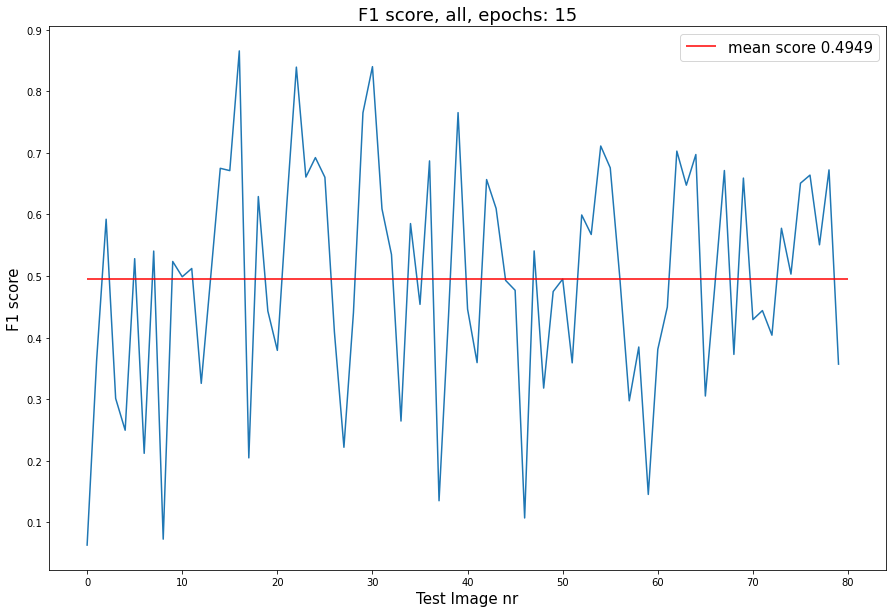

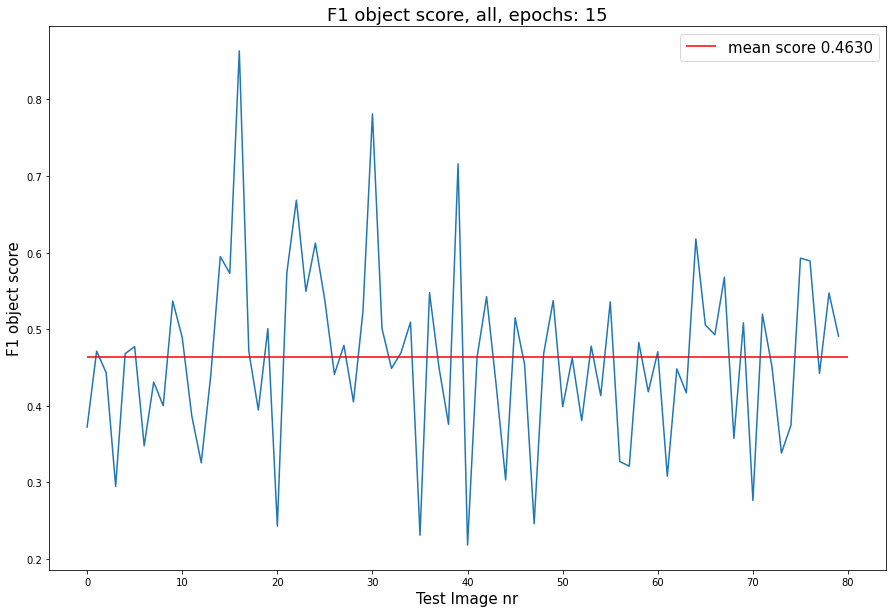

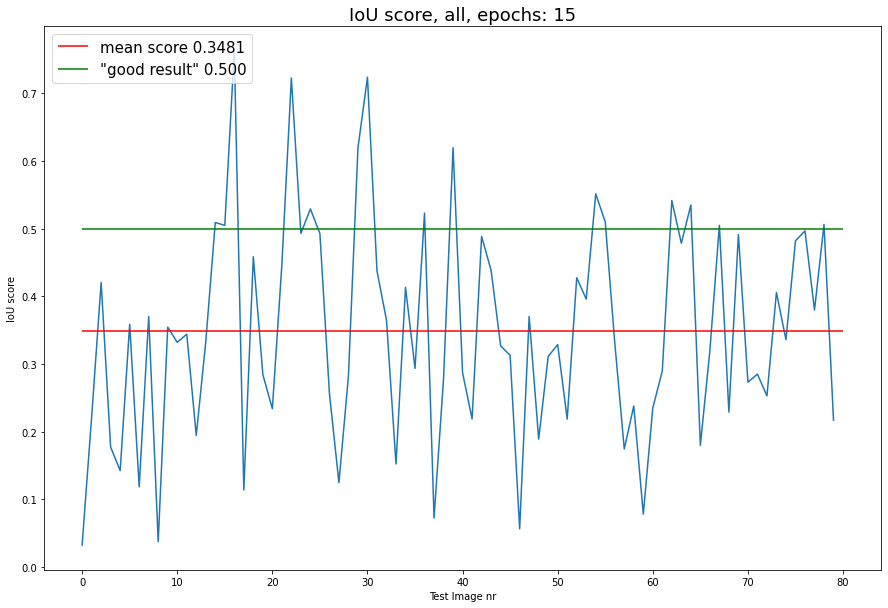

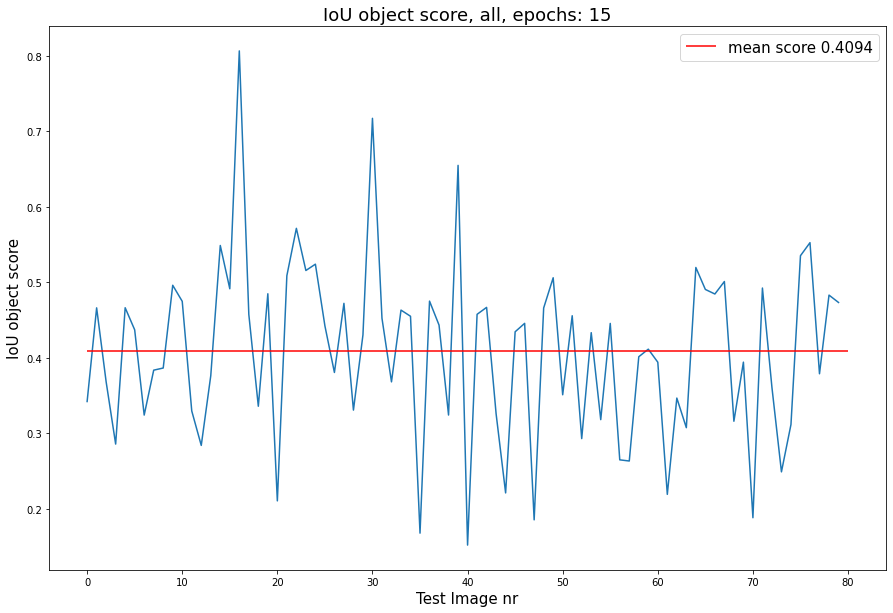

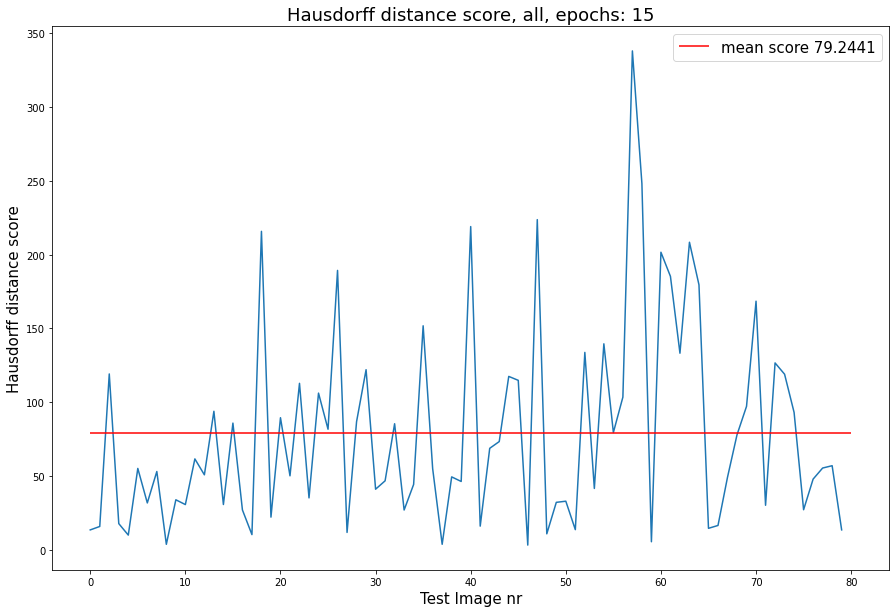

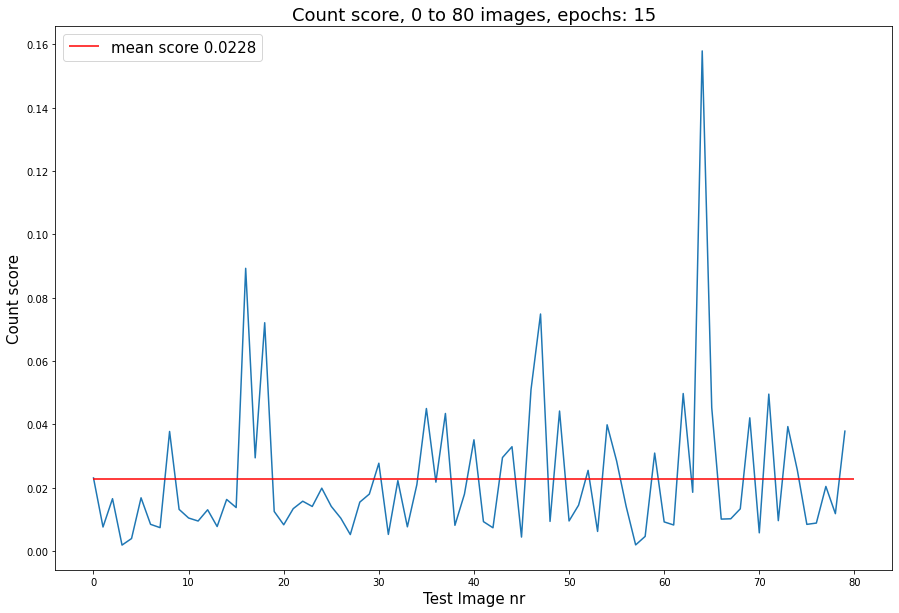

In [ ]:

xmaxlim = img_nr+1
#F1 score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(F1_all)
F1_mean = np.mean(F1_all)
plt.title('F1 score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('F1 score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(F1_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(F1_mean))
ax.legend(prop={"size":15})
#F1 object score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(F1_obj_all)
F1_obj_mean = np.mean(F1_obj_all)
plt.title('F1 object score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('F1 object score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(F1_obj_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(F1_obj_mean))
ax.legend(prop={"size":15})

#Hausdorff distance score
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(hausdorff_obj_distance_all)
Hausdorff_mean = np.mean(hausdorff_obj_distance_all)
plt.title('Hausdorff distance score, all, epochs: {}'.format(num_epochs), fontsize=18)
plt.ylabel('Hausdorff distance score', fontsize=15)
plt.xlabel('Test Image nr', fontsize=15)
plt.hlines(Hausdorff_mean, 0, xmaxlim,colors="r", zorder=100, label='mean score {:.4f}'.format(Hausdorff_mean))
ax.legend(prop={"size":15})
